# Task two

In task two we are looking at Pacific Sea Surface Temperature (SST) and local forecasts.
The two datasets we will be using for this are:

* the global SST data used in week four (1960-2016)
* the SST data recoreded at at Port Vila (Vanuatu) between 1993 and 2021.

We will predominantly use pricipal component analysis to develop a model based on a subset of the global SST data.
The subset of global SST data used will be of the Pacific region that includes the station I have chosed (Port Vila Vanuatu)
To test the PC model we then try and predict the temperature recorded at the location chosen in the Pacific region and compare the outputs with the recorded data.

## Part one

First we analyse the global SST data.
This data is **describe data here**.
Julia has a few things similar to python's `xarray` with the most developed one being `DimensionalData.jl`.
This has been used to create a package specific to spatial data called `GeoData.jl` which is what I will use.
The `GeoData.jl` package is designed to work with netCD4 data though I have run into some issues either some of the packages, the data, my coding (or all three) which meant I have had to alter the way I do things.
First set up the julia environment and load the required packages.

In [48]:
using Pkg
Pkg.activate("..")
using Plots, Statistics, Glob, Dates, GeoData, NCDatasets, LinearAlgebra

  Activating environment at `~/Documents/GitHub/MATH5271/Project.toml`


### Reading in SST data

The data is provided in the netCD4 format so this is firs read in using `NCDataset`.
I have cloned the [data repository](https://github.com/pangeo-data/tutorial-data) which contains all the data we looked at in lab 4 to my machine so there is no need to mount anything.
Instead just specify the file path and the create a vector containing the file names using the `glob` function.

In [2]:
SST_datapath = joinpath("../..", "globalSST/sst")
globalSST_data = glob(joinpath(SST_datapath, "*.nc"))
globalSST_file = NCDataset(globalSST_data; aggdim = "time")

NCDataset: ../../globalSST/sst/NOAA_NCDC_ERSST_v3b_SST-1960.nc…../../globalSST/sst/NOAA_NCDC_ERSST_v3b_SST-2016.nc
Group: /

Dimensions
   lat = 89
   lon = 180
   time = 684

Variables
  lat   (89)
    Datatype:    Float32
    Dimensions:  lat
    Attributes:
     _FillValue           = NaN
     standard_name        = latitude
     pointwidth           = 2.0
     gridtype             = 0
     units                = degree_north

  lon   (180)
    Datatype:    Float32
    Dimensions:  lon
    Attributes:
     _FillValue           = NaN
     standard_name        = longitude
     pointwidth           = 2.0
     gridtype             = 1
     units                = degree_east

  sst   (180 × 89 × 684)
    Datatype:    Float32
    Dimensions:  lon × lat × time
    Attributes:
     _FillValue           = -999.0
     pointwidth           = 1.0
     valid_min            = -3.0
     valid_max            = 45.0
     units                = degree_Celsius
     long_name            = Extended reco

We can see that by reading in the data this way we get some information similar to `xarray` (though not as nicely laid out).
Now it is a matter of turning this `NCDataset` into a `GeoArray` so that all the features this package provides can be taken advantage of.
This is where I had some trouble.
The issue I have ran into was the `lat` and `lon` variables from the `NCDataset` were read in as unordered categorical arrays to the `GeoArray`.
This meant that plotting and choosing slices of data (by `lat` or `lon`) was not possible as it thought the numbers were categorical arrays.

After much trying the workaround I came up with was to create numeric vectors of the same length and stepsize as the `lat` and `lon` from the `NCDataset` then use these to create the `GeoArray`.
This does lose some information but I did make sure that the critical information was retained and if need be I can always refer back to the `NCDataset`.

Extract the data (SST) latitude, longitude and time from the `NCDataset`, then create new ordered numeric versions of the latitude and longitude.

In [3]:
timelength =  globalSST_file["time"][:]
sst =  globalSST_file["sst"]

#Create custom dimension types
@dim Lat YDim "Latitude (degrees north)"
@dim Lon XDim "Longitude (degrees east)"
lon = 0:2:358
lat = -88:2:88
dimensions = (Lon(lon), Lat(lat), Ti(timelength))


  Lon (Longitude (degrees east)): 0:2:358,
  Lat (Latitude (degrees north)): -88:2:88,
  Ti (Time): DateTime[1960-01-15T00:00:00, …, 2016-12-15T00:00:00]

Now we have the data and the dimensions we can generate the `GeoArray` and plot to see if it matches what we saw in lab 4.
We look at the full plot, the plot at zero latitude of the first recording then a time series of this as well

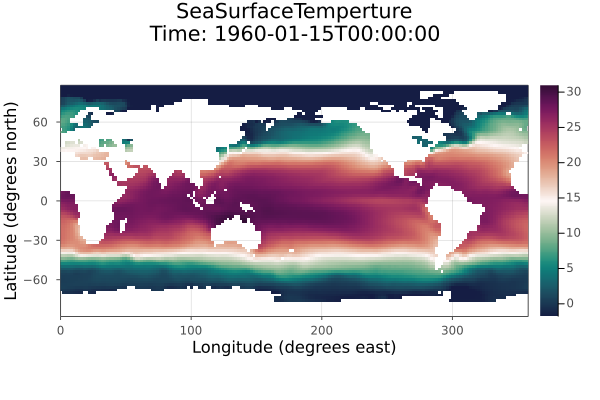

In [4]:
SSTglobal = GeoArray(sst, dimensions, name = :SeaSurfaceTemperture)
SSTglobal[Ti(1)] |> plot

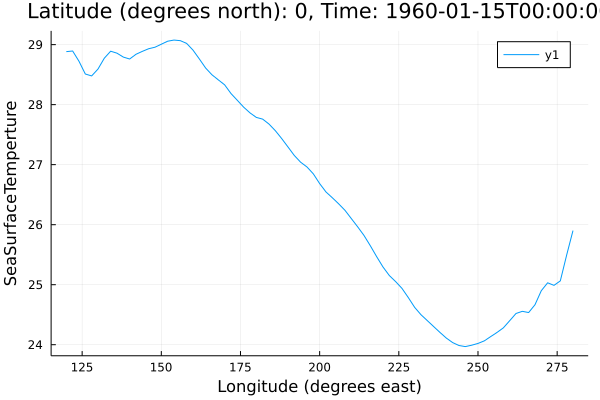

In [6]:
SSTglobal[Lon(Between(120, 280)), Lat(At(0)), Ti(1)] |> plot

By default the plot of the time series has time along the x axis.
This is fine and may be used though it is also possible to generate the heatmap orientated the other way by usual plotting methods.

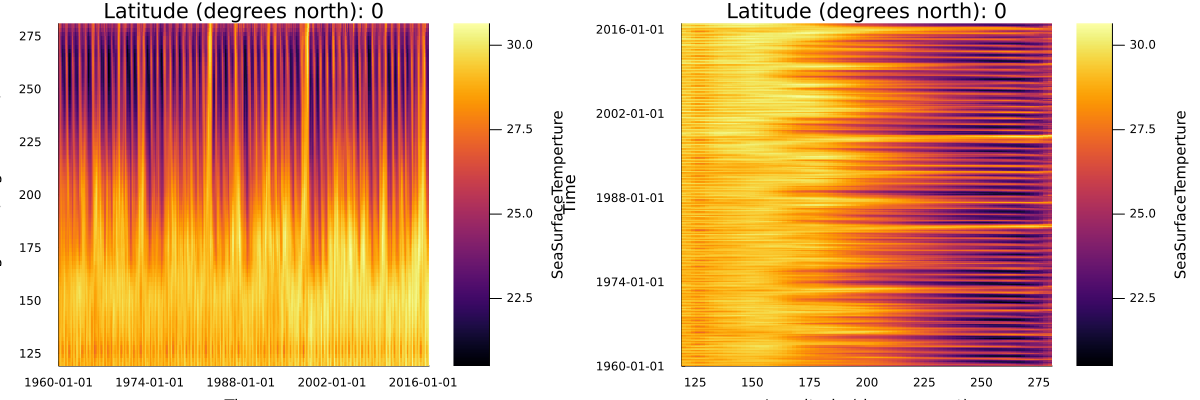

In [5]:
long_ts = SSTglobal[Lon(Between(120, 280)), Lat(At(0)), Ti()] 
plot1 = long_ts |> heatmap
plot2 = heatmap(120:2:280, timelength, long_ts', 
                title = "Latitude (degrees north): 0",
                xlabel = "Longitude (degrees east)",
                ylabel = "Time",
                colorbar_title  = "SeaSurfaceTemperture")
plot(plot1, plot2, size = (1200, 400), layout = (1, 2))

From this we can see that the plots are matching up with what we saw in lab 4 so all seems to be fine on the SST data front.]
I will use the plotting provided by the `GeoData.jl` package (the one on the left above that has `Time` on the `xaxis`) for the rest of this task.

### SST anomaly

From the `SSTglobal` data we want to generate the anomaly.
This is computed in a simialr to the `xarray` package by taking the `mean` over the time dimension using the `GeoData.jl` package.

This does look to be the anomlay for this time series though I do not think this is the same as the annual anomaly computed in lab 4. 
Need to look into if that is something different and if it is whether or not it is a problem.

In [69]:
#SST_mean = mean(SSTglobal; dims = Ti)
long_ts_mean = mean(long_ts, dims = Ti)
long_ts_mean = repeat(long_ts_mean, outer = (1, 684))
long_ts_anom = long_ts .- long_ts_mean

81×684 GeoArray{Float32,2} with dimensions: 
  Lon (Longitude (degrees east)): 120:2:280 Sampled: Ordered Regular Points,
  Ti (Time): DateTime[1960-01-15T00:00:00, …, 2016-12-15T00:00:00]
    Sampled: Ordered Irregular Points
and reference dimensions: 
  Lat (Latitude (degrees north)): 0 Sampled: Ordered Regular Points
with missingval:  -0.292576  -0.664572  -0.35651     …   0.617128   0.748432  0.611536
 -0.256786  -0.562977  -0.194765        0.700951   0.914425  0.723082
 -0.268736  -0.511206  -0.053957        0.855648   1.13181   0.853336
 -0.346811  -0.572449  -5.14984f-5      1.03136    1.31967   0.916191
 -0.404209  -0.611523   0.00692558      1.10757    1.3513    0.873158
 -0.415167  -0.598204  -0.0307503   …   1.09947    1.25735   0.783867
  ⋮                                 ⋱                        
  0.372816   1.27841    1.45607        -1.10035   -0.857878  0.0463257
  0.347939   1.1605     1.21366        -1.23961   -1.04581   0.0552158
  0.332758   1.05763    1.04803      

missing


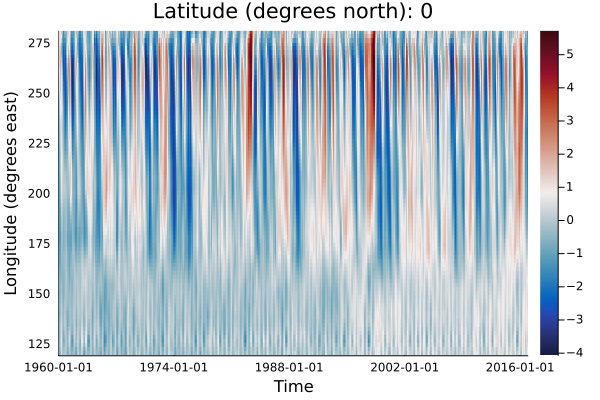

In [70]:
heatmap(long_ts_anom, color = :balance)

Now want to compute the covariance matrix and get the eigenvectors for form the principal components.
I think the anomaly of the time series is not the same as what Jan produces in lab 4 so this is different.

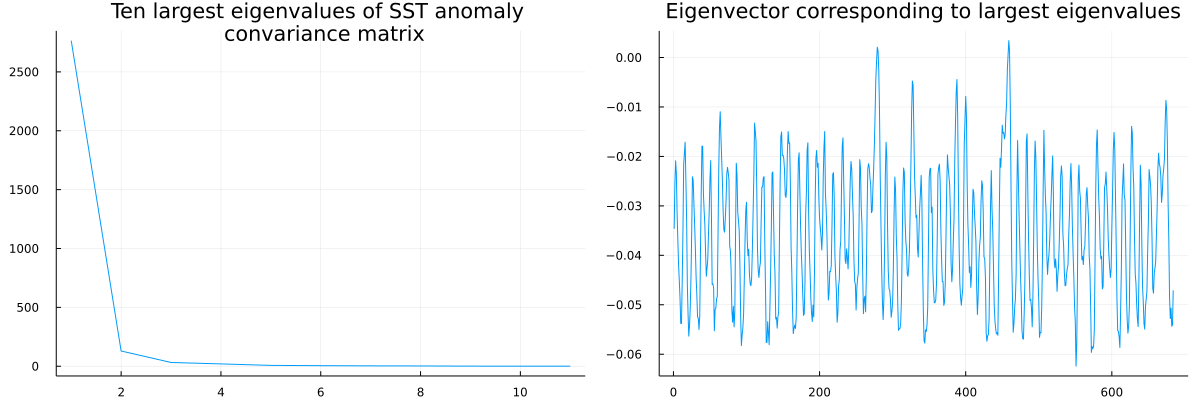

In [71]:
C_lont_ts = cov(long_ts_anom)
Cmat = reshape(cov(long_ts)[:], (684, 684))
Eigen_decomp_Cmat = eigen(Cmat)
plot(plot(Eigen_decomp_Cmat.values[end:-1:end-10], title = "Ten largest eigenvalues of SST anomaly \n convariance matrix", label = false),
    plot(Eigen_decomp_Cmat.vectors[:, end], title = "Eigenvector corresponding to largest eigenvalues", label = false),
    layout = (1, 2), 
    size = (1200, 400)
)

Now compute the first pricipal component $\mathbf{u}_{1}$.

In [101]:
e₁ = Eigen_decomp_Cmat.vectors[:, end]
e₁' .* long_ts_anom[:, :]

81×684 GeoArray{Float32,2} with dimensions: 
  Lon (Longitude (degrees east)): 120:2:280 Sampled: Ordered Regular Points,
  Ti (Time): DateTime[1960-01-15T00:00:00, …, 2016-12-15T00:00:00]
    Sampled: Ordered Irregular Points
and reference dimensions: 
  Lat (Latitude (degrees north)): 0 Sampled: Ordered Regular Points
with missingval:   0.0101323    0.0168474  …  -0.0335517  -0.040447   -0.0287969
  0.00889282   0.0142719     -0.0381089  -0.0494176  -0.0340495
  0.00930665   0.0129595     -0.0465195  -0.0611654  -0.0401831
  0.0120105    0.014512      -0.0560726  -0.0713178  -0.0431429
  0.0139982    0.0155026     -0.0602158  -0.0730275  -0.0411164
  0.0143777    0.0151649  …  -0.0597755  -0.0679501  -0.0369118
  ⋮                       ⋱                          
 -0.0129111   -0.0324086      0.0598234   0.0463617  -0.00218145
 -0.0120495   -0.0294197      0.0673946   0.056518   -0.00260008
 -0.0115238   -0.0268118      0.0748076   0.0673137  -0.00199472
 -0.0136768   -0.0273076    

missing
